# PAM's Descriptive Analysis

This file contains all the code & analysis developed for the paper titled XXX.

In this section we will analyse the PAM's datasets. 

In [1]:
# Packages
import os 
import io
import requests
import pandas as pd
import numpy as np
#from langdetect import detect
import re
import yaml
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', -1) # print long strings

#from adjustText import adjust_text

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

/home/avaldivia/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/avaldivia/env37/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  del sys.path[0]


In [2]:
# Read yaml file 
with open('config_file.yaml', 'r') as f:
    config = yaml.load(f)

/home/avaldivia/env37/lib/python3.7/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


## 1. Proposals

### 1.1. Clean proposals dataset

In [3]:
# Read proposals dataset
df = pd.read_csv(config['ROOT_PATH'] + '/data/' + 'proposals_all.csv', sep=',', encoding='utf-8')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10860 entries, 0 to 10859
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      10860 non-null  int64 
 1   proposal        10860 non-null  int64 
 2   origin          10860 non-null  object
 3   scope           10860 non-null  object
 4   district        7172 non-null   object
 5   category        10860 non-null  object
 6   subcategory     10860 non-null  object
 7   author          10860 non-null  object
 8   author_name     10133 non-null  object
 9   created_at      10860 non-null  object
 10  votes           10860 non-null  int64 
 11  comments        10860 non-null  int64 
 12  url             10860 non-null  object
 13  status          10860 non-null  object
 14  title_es        10860 non-null  object
 15  title_ca        10860 non-null  object
 16  description_es  10860 non-null  object
 17  description_ca  10860 non-null  object
 18  Unname

In [9]:
# Change some column types
df = df.astype({'proposal': 'object'})
df['proposal'] = df['proposal'].astype(str)
df['status'] = df['status'].apply(str)

In [10]:
# What does 0 and 1 mean in the status column?
# status == '0' is equal to status == 'rejected'

# Clean status

df['status'] = np.where(df['status'] == '0', 'rejected', df['status'])
df['status'] = np.where(df['status'] == '1', 'accepted', df['status'])

In [11]:
# Clean text
def clean_text(data):
    data = data.str.replace(u'Ã±', 'ñ')
    data = data.str.replace(u'Â·', '·')
    data = data.str.replace(u'â€¢', '·')
    data = data.str.replace(u'Ã§', 'ç')
    data = data.str.replace(u'Ã©', 'é')
    data = data.str.replace(u'Ã¨', 'è')
    data = data.str.replace(u'Ã\xad', 'í')
    data = data.str.replace(u'ÃÂ­', 'í')
    data = data.str.replace(u'Ã¯', 'ï')
    data = data.str.replace(u'ÃÂ¯', 'ï')
    data = data.str.replace(u'Ã³', 'ó')
    data = data.str.replace(u'ÃÂ³', 'ó')
    data = data.str.replace(u'ÃÂ²', 'ò')
    data = data.str.replace(u'Ã²', 'ò')
    data = data.str.replace(u'Ãº', 'ú')
    data = data.str.replace(u'Ã¼', 'ü')

    data = data.str.replace(u'â', "'")
    data = data.str.replace(u'Ã\xa0', 'à')
    data = data.str.replace(u'Ã\x83Â\xa0', 'à')
    
    data = data.str.replace(u'<p>', '')
    data = data.str.replace(u'<div>', '')
    data = data.str.replace(u'<br>', '')
    data = data.str.replace(u'</p>', '')
    data = data.str.replace(u'</div>', '')
    
    data = data.str.replace(u'Ã\x89', 'é')
    data = data.str.replace(u'Ã¡', 'á')
    
    

    return data

In [12]:
# Apply clean text
df['district'] = clean_text(df['district'])
df['category'] = clean_text(df['category'])
df['subcategory'] = clean_text(df['subcategory'])
df['author_name'] = clean_text(df['author_name'])
df['title_es'] = clean_text(df['title_es'])
df['title_ca'] = clean_text(df['title_ca'])
df['description_es'] = clean_text(df['description_es'])
df['description_ca'] = clean_text(df['description_ca'])

In [13]:
# Create 'group_author' variable which aggregates author's name
df['group_author'] =  np.where(df['author_name'] == 'Ajuntament de Barcelona', 'administration', 'citizens')

In [14]:
# Add language columns
# read the original dataset (without translations)
url = 'https://raw.githubusercontent.com/elaragon/metadecidim/master/proposals.tsv'
s = requests.get(url).content
df_origin = pd.read_csv(io.StringIO(s.decode('utf-8')), sep = '\t')

# Create column with language of proposal
def detect_lang(x):
    try:
        return detect(x)
    except:
        return 'null'
    
    
df_origin['language'] = df_origin['summary'].apply(detect_lang)
df_origin['language'].value_counts()

# Clean different languages wrongly detected
df_origin[['summary', 'language']].loc[(df_origin['language'] != 'ca') & (df_origin['language'] != 'es')]
df_origin.loc[((df_origin['language'] != 'ca') & (df_origin['language'] != 'es') & (df_origin['language'] != 'null')), 'language'] = 'ca' # all different languages are indeed catalan


In [15]:
# Merge this new column with df
df_origin_aux = df_origin[['id', 'total_positive_comments', 'total_neutral_comments', 'total_negative_comments', 'rejected_message', 'language']]
df_origin_aux['id'] = df_origin_aux['id'].astype(str)
df = pd.merge(df, df_origin_aux, left_on=  ['proposal'], right_on= ['id'], how = 'left')

/home/avaldivia/env37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
# Take a look to the name of columns
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'id'])
df.columns

Index(['proposal', 'origin', 'scope', 'district', 'category', 'subcategory', 'author', 'author_name', 'created_at', 'votes', 'comments', 'url', 'status', 'title_es', 'title_ca', 'description_es', 'description_ca', 'group_author', 'total_positive_comments', 'total_neutral_comments', 'total_negative_comments', 'rejected_message', 'language'], dtype='object')

In [17]:
df.head(1)

,proposal,origin,scope,district,category,subcategory,author,author_name,created_at,votes,comments,url,status,title_es,title_ca,description_es,description_ca,group_author,total_positive_comments,total_neutral_comments,total_negative_comments,rejected_message,language
0,3591,citizenship,district,Nou Barris,Economia plural,Un nou lideratge públic,5187,VILLARRASA,2/27/2016,16,0,https://decidim.barcelona.cat/proposals/reduccion-del-ibi-de-las-viviendas-de-torre-baro,rejected,Reducción del IBI de las viviendas de TORRE BARÃN,Reducció de l'IBI dels habitatges de TORRE BARÃ,"Revisar el alto valor que se paga del Impuesto de Bienes Inmuebles en Torre Baró, sobre todo aquellas fincas construidas a partir del año 2001.Revisión de la categoría de calles, del valor del suelo y de la construcción con el Objeto que el valor catastral se reduzca Hasta el punto que se corresponda con la realidad de las fincas y super entorno.","Revisar l'alt valor que es paga l'Impost de Béns Immobles a Torre Baró, sobretot aquelles finques construïdes a partir de l'any 2001.Revisión de la categoria de carrers, del valor del sòl i de la construcció amb l'objecte que el valor cadastral es redueixi fins al punt que es correspongui amb la realitat de les finques i el seu entorn.",citizens,0,0,0,"No hi ha competències i l’Ajuntament no disposa de la capacitat d’influir. No obstant això, el govern municipal està treballant en la recerca de solucions alternatives per reduir l'import de l'IBI en barris com Torre Baró, que considerem injust.",null


### Votes, comments, district and category analysis

In [13]:
# Summary of variables
df_aux = df[['votes', 'comments', 'district', 'category', 'status', 'group_author', 'language']]
summary_list = [df_aux.describe()] + \
               [df_aux.groupby([c])[df_aux.columns[0]].count() \
                for c in df_aux.columns if df_aux[c].dtype == 'object']

for i in summary_list:
    print(i)
    print()

              votes      comments
count  10860.000000  10860.000000
mean   15.201842     1.675046    
std    43.845657     5.708035    
min    0.000000      0.000000    
25%    1.000000      0.000000    
50%    5.000000      0.000000    
75%    15.000000     1.000000    
max    1720.000000   337.000000  

district
Ciutat Vella             971
Eixample                 539
Gràcia                   713
Horta - Guinardó         606
Les Corts                585
None                     824
Nou Barris               444
Sant Andreu              516
Sant Martí               817
Sants Montjuïc           685
Sarrià - Sant Gervasi    472
Name: votes, dtype: int64

category
Bon govern             888 
Bon viure              4867
Economia plural        1368
Justícia global        62  
Transició ecològica    3675
Name: votes, dtype: int64

status
accepted    8142
rejected    2718
Name: votes, dtype: int64

group_author
administration    1305
citizens          9555
Name: votes, dtype: int64

language

Proposals usually obtain a low number of votes (75% of them obtained at most 15 votes), although, the analysis shows that some proposals were very popular (with at most 1,720 votes). The distribution of comments also exposes that most of them (75%) obtained at least 1 comments. However, some of them were very commented (max. is 337).

The district with more proposals was Ciutat Vella, with at least 971 proposals. On the other hand, the Sarrià SAnt Gervasi was the least participative. 

The most popular category was Bon viure, the least 'Justicia Global'.

/home/avaldivia/env37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of votes on accepted proposals')

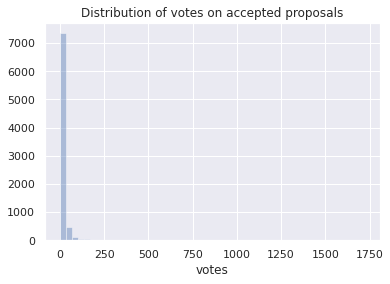

In [14]:
# Distribution of votes on accepted proposals
sns.distplot(df_aux.loc[(df_aux['status']=='accepted'), 
            'votes'], color='b', kde=False, label = "accepted")   
plt.xlabel('votes') 
plt.title('Distribution of votes on accepted proposals')

Text(0.5, 1.0, 'Distribution of votes on rejected proposals')

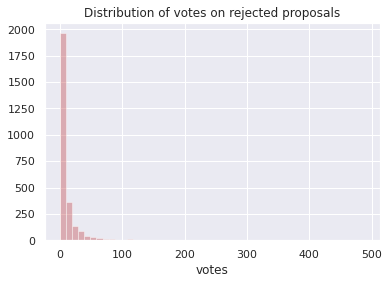

In [15]:
# Distribution of votes on rejected proposals
sns.distplot(df_aux.loc[(df_aux['status']=='rejected'), 
            'votes'], color='r',kde=False, label = "rejected")  
plt.xlabel('votes')
plt.title('Distribution of votes on rejected proposals')

Text(0.5, 1.0, 'Distribution of comments on accepted proposals')

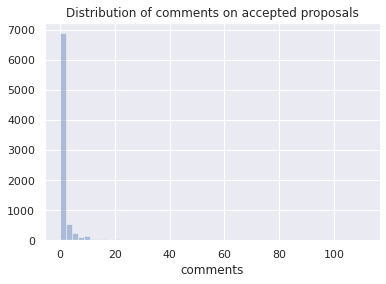

In [16]:
# Distribution of comments on accepted proposals
sns.distplot(df_aux.loc[(df_aux['status']=='accepted'), 
            'comments'], color='b', kde=False, label = "accepted") 

plt.xlabel('comments')
plt.title('Distribution of comments on accepted proposals')

Text(0.5, 1.0, 'Distribution of comments on rejected proposals')

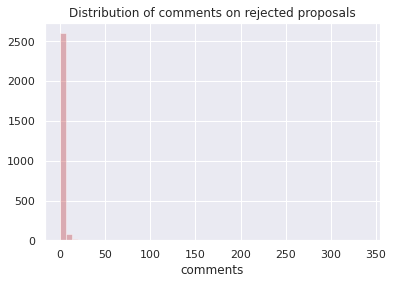

In [17]:
# Distribution of comments on rejected proposals
sns.distplot(df_aux.loc[(df_aux['status']=='rejected'), 
            'comments'], color='r', kde=False, label = "rejected")  

plt.xlabel('comments')
plt.title('Distribution of comments on rejected proposals')

In [18]:
# Analysis of participation and status per district
df_cross_tab = df_aux.loc[(df_aux['district'] != 'None')]
df_cross_tab = pd.crosstab(df_cross_tab.district, df_cross_tab.status, margins = True, margins_name = 'all').reset_index()
df_cross_tab['p_accepted'] = 100*(df_cross_tab['accepted']/df_cross_tab['all'])
df_cross_tab['p_rejected'] = 100*(df_cross_tab['rejected']/df_cross_tab['all'])
total_proposals = df_cross_tab.loc[(df_cross_tab['district'] == 'all')]['all'][10]
df_cross_tab['total'] = total_proposals
df_cross_tab['p_total'] = 100*(df_cross_tab['all']/df_cross_tab['total'])
df_cross_tab = df_cross_tab.round(2)
df_cross_tab = df_cross_tab.loc[(df_cross_tab['district'] != 'all')]

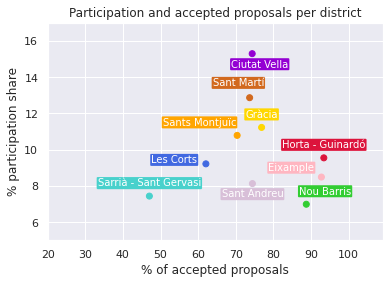

In [19]:
# Plot of analysis of participation and status per district
xs = df_cross_tab['p_accepted']
ys = df_cross_tab['p_total']
zs = df_cross_tab['district']
cs = ['darkviolet', 'lightpink', 'gold', 'crimson', 'royalblue', 'limegreen', 'thistle' , 'chocolate', 'orange', 'mediumturquoise']
plt.scatter(xs, ys, color=cs)



for x,y,z,c in zip(xs,ys, zs, cs):

    #label = "{:.2f}".format(x)
    #plt.annotate(label, # this is the text
                 #(x,y), # this is the point to label
                 #textcoords="offset points", # how to position the text
                 #color = 'black',
                 #xytext=(3,6), # distance from text to points (x,y)
                 #ha='right') # horizontal alignment can be left, right or center
    
    label = z
    if label == 'Les Corts':
        plt.annotate(label, # this is the text
                 (x-2.3,y-0.5), # this is the point to label,
                 color = 'white', # color of text
                 textcoords="offset points", # how to position the text,
                 bbox=dict(boxstyle="round,pad=0.1", fc=c, ec=c, lw=0.01), # this is the box for the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='right', fontsize = 10) # horizontal alignment can be left, right or center
        
    elif z == 'Sant Andreu':
        plt.annotate(label, # this is the text
                 (x,y-1.3), # this is the point to label,
                 color = 'white', # color of text
                 textcoords="offset points", # how to position the text,
                 bbox=dict(boxstyle="round,pad=0.1", fc=c, ec=c, lw=0.01), # this is the box for the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center', fontsize = 10) # horizontal alignment can be left, right or center   
    elif z == 'Nou Barris':
        plt.annotate(label, # this is the text
                 (x+5,y), # this is the point to label,
                 color = 'white', # color of text
                 textcoords="offset points", # how to position the text,
                 bbox=dict(boxstyle="round,pad=0.1", fc=c, ec=c, lw=0.01), # this is the box for the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center', fontsize = 10) # horizontal alignment can be left, right or center    
    elif z == 'Sant Martí':
        plt.annotate(label, # this is the text
                 (x-3,y+0.1), # this is the point to label,
                 color = 'white', # color of text
                 textcoords="offset points", # how to position the text,
                 bbox=dict(boxstyle="round,pad=0.1", fc=c, ec=c, lw=0.01), # this is the box for the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center', fontsize = 10) # horizontal alignment can be left, right or center    
    elif z == 'Ciutat Vella':
        plt.annotate(label, # this is the text
                 (x+2,y-1.3), # this is the point to label,
                 color = 'white', # color of text
                 textcoords="offset points", # how to position the text,
                 bbox=dict(boxstyle="round,pad=0.1", fc=c, ec=c, lw=0.01), # this is the box for the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center', fontsize = 10) # horizontal alignment can be left, right or center
    elif z == 'Sants Montjuïc':
        plt.annotate(label, # this is the text
                 (x-10,y), # this is the point to label,
                 color = 'white', # color of text
                 textcoords="offset points", # how to position the text,
                 bbox=dict(boxstyle="round,pad=0.1", fc=c, ec=c, lw=0.01), # this is the box for the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center', fontsize = 10) # horizontal alignment can be left, right or center 
    elif z == 'Eixample':
        plt.annotate(label, # this is the text
                 (x-8,y-0.2), # this is the point to label,
                 color = 'white', # color of text
                 textcoords="offset points", # how to position the text,
                 bbox=dict(boxstyle="round,pad=0.1", fc=c, ec=c, lw=0.01), # this is the box for the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center', fontsize = 10) # horizontal alignment can be left, right or center 
    else:
        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label,
                     color = 'white', # color of text
                     textcoords="offset points", # how to position the text,
                     bbox=dict(boxstyle="round,pad=0.1", fc=c, ec=c, lw=0.1), # this is the box for the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center', fontsize = 10) # horizontal alignment can be left, right or center

#plt.legend(zs)
plt.xticks()
plt.yticks()
plt.xlim((20,109))
plt.ylim((5,17))
plt.xlabel('% of accepted proposals')
plt.ylabel('% participation share')
plt.title('Participation and accepted proposals per district')
plt.grid(True)

plt.show()

In [20]:
# Analysis of participation and status per category
df_cross_tab = df_aux
df_cross_tab = pd.crosstab(df_cross_tab.category, df_cross_tab.status, margins = True, margins_name = 'all').reset_index()
df_cross_tab['p_accepted'] = 100*(df_cross_tab['accepted']/df_cross_tab['all'])
df_cross_tab['p_rejected'] = 100*(df_cross_tab['rejected']/df_cross_tab['all'])
#total_proposals = df_cross_tab.loc[(df_cross_tab['category'] == 'all')]['all'][10]
df_cross_tab['total'] = total_proposals
df_cross_tab['p_total'] = 100*(df_cross_tab['all']/df_cross_tab['total'])
df_cross_tab = df_cross_tab.round(2)
df_cross_tab = df_cross_tab.loc[(df_cross_tab['category'] != 'all')]

In [21]:
df_cross_tab

status,category,accepted,rejected,all,p_accepted,p_rejected,total,p_total
0,Bon govern,677,211,888,76.24,23.76,6348,13.99
1,Bon viure,3725,1142,4867,76.54,23.46,6348,76.67
2,Economia plural,1077,291,1368,78.73,21.27,6348,21.55
3,Justícia global,40,22,62,64.52,35.48,6348,0.98
4,Transició ecològica,2623,1052,3675,71.37,28.63,6348,57.89


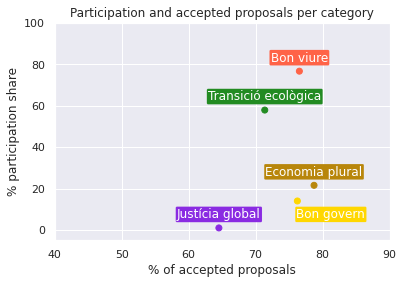

In [22]:
# Plot of analysis of participation and status per district
xs = df_cross_tab['p_accepted']
ys = df_cross_tab['p_total']
zs = df_cross_tab['category']
cs = ['gold', 'tomato', 'darkgoldenrod', 'blueviolet', 'forestgreen']
plt.scatter(xs, ys, color=cs)



for x,y,z,c in zip(xs,ys, zs, cs):

    #label = "{:.2f}".format(x)
    #plt.annotate(label, # this is the text
                 #(x,y), # this is the point to label
                 #textcoords="offset points", # how to position the text
                 #color = 'black',
                 #xytext=(3,6), # distance from text to points (x,y)
                 #ha='right') # horizontal alignment can be left, right or center
    
    label = z
    if label == 'Bon govern':
        plt.annotate(label, # this is the text
                 (x+5,y-13), # this is the point to label,
                 color = 'white', # color of text
                 textcoords="offset points", # how to position the text,
                 bbox=dict(boxstyle="round,pad=0.1", fc=c, ec=c, lw=0.01), # this is the box for the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center', fontsize = 12) # horizontal alignment can be left, right or center
  
    else:
        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label,
                     color = 'white', # color of text
                     textcoords="offset points", # how to position the text,
                     bbox=dict(boxstyle="round,pad=0.1", fc=c, ec=c, lw=0.1), # this is the box for the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center', fontsize = 12) # horizontal alignment can be left, right or center

#plt.legend(zs)
plt.xticks()
plt.yticks()
plt.xlim((40,90))
plt.ylim((-5,100))
plt.xlabel('% of accepted proposals')
plt.ylabel('% participation share')
plt.title('Participation and accepted proposals per category')
plt.grid(True)

plt.show()

### Accepted vs. rejected and (author, origin, district, category, language)

In [23]:
# Authors with most accepted proposals
df[['author_name', 'status']].pivot_table(index='author_name', columns='status', aggfunc=len, fill_value=0).sort_values(by='accepted', ascending = False).reset_index()[0:11]

status,author_name,accepted,rejected
0,Ajuntament de Barcelona,1248,57
1,None,653,193
2,suport decidim.HG i Les Corts,342,154
3,suport decidim.barcelona,313,78
4,Suport Ciutat Vella,217,73
5,GR_Raons Públiques,202,52
6,Suport General - Decidim Barcelona,200,106
7,Suport decidim Activitat Econòmica,183,40
8,suport.decidim1,169,33
9,suportdecidim.santandreu,165,72


In [18]:
# Authors with most rejected proposals
df[['author_name', 'status']].pivot_table(index='author_name', columns='status', aggfunc=len, fill_value=0).sort_values(by='rejected', ascending = False).reset_index()[0:11]


status,author_name,accepted,rejected
0,None,653,193
1,suport decidim.HG i Les Corts,342,154
2,Suport General - Decidim Barcelona,200,106
3,decidim sarrià-sant gervasi,84,102
4,suport decidim.barcelona,313,78
5,Suport Ciutat Vella,217,73
6,suportdecidim.santandreu,165,72
7,Ajuntament de Barcelona,1248,57
8,Dsoriano,71,55
9,GR_Raons Públiques,202,52


In [25]:
df.loc[df['author_name'] == 'Dsoriano']

,proposal,origin,scope,district,category,subcategory,author,author_name,created_at,votes,comments,url,status,title_es,title_ca,description_es,description_ca,group_author,total_positive_comments,total_neutral_comments,total_negative_comments,rejected_message,language
13,8146,meeting,city,NaN,Transició ecològica,Medi ambient i espai públic,13405,Dsoriano,4/4/2016,3,0,https://decidim.barcelona.cat/proposals/campanya-per-sensibilitzar-sobre-el-descans-nocturn-del-veinat,accepted,Campaña para sensibilizar sobre el descanso nocturno del vecindario,Campanya per sensibilitzar sobre el Descans nocturn del veïnat,"En la cita presencial de la Escuela Betània- Patmos, los estudiantes de 3Âº de ESO C estuvieron debatiendo varias propuestas para mejorar el medio ambiente de la ciudad, entre éstas propusieron hacer una campaña para sensibilizar y concienciar a la ciudadanía sobre el respecto nocturno del vecindario.","A la cita presencial de l'Escola Betània- Patmos, a els estudiants de 3r d'ESO C van estar debatent Diverses Propostes per Millorar el medi ambient de la ciutat, entre aquestes van proposar Fer una campanya per sensibilitzar i conscienciar a la ciutadania sobre el respecte nocturn del veïnat.",citizens,0,0,0,None,null
109,7252,meeting,city,NaN,Transició ecològica,Mobilitat sostenible,13405,Dsoriano,3/29/2016,2,0,https://decidim.barcelona.cat/proposals/creacio-de-parquings-de-bicicletes-a-les-escoles,accepted,Creación de aparcamientos de bicicletas en las escuelas,Creació de pàrquings de bicicletes a les escoles,En la cita presencial de la Escuela Pia Sant Antoni se propuso crear un parking de bicicletas cerrado dentro la escuela para no dejarlas en la calle donde a menudo las roban o destrozan. Los alumnos que quieran dejar la bicicleta en este parking podrían tener un carnet y así asegurar un cierto control de personas que dejan la bicicleta.,A la cita presencial de l'Escola Pia Sant Antoni és va proposar crear un pàrquing de bicicletes tancat a dins de l'escola per tal de no Deixar-les al carrer on sovint els robin o destrossen. Els alumnes que vulguin Deixar la bicicleta a AQUEST pàrquing podríen Tenir un carnet i AIXÃ assegurar 1 cert control de persones que deixen la bicicleta.,citizens,0,0,0,None,null
111,7193,meeting,city,NaN,Transició ecològica,Mobilitat sostenible,13405,Dsoriano,3/29/2016,0,0,https://decidim.barcelona.cat/proposals/creacio-de-plataformes-des-de-les-escoles-per-compartir-cotxe,accepted,Creación de plataformas desde las escuelas para compartir coche,Creació de plataformes des de les escoles per compartir cotxe,"Con el fin de paliar el tráfico en la ciudad de Barcelona en las horas puntas, a la cita presencial que tuvo lugar en el Jardín de las niñez se propuso el impulso de plataformas desde las escuelas para compartir coche.","Per tal de pal·liar el trànsit a la ciutat de Barcelona a les hores puntes, a la cita presencial que va Tenir lloc a Jardí de les Infanteses és va proposar l'impuls de plataformes des de les escoles per compartir cotxe.",citizens,0,0,0,None,null
250,9151,meeting,district,Sant Martí,Bon viure,Educació i coneixement,13405,Dsoriano,4/7/2016,1,1,https://decidim.barcelona.cat/proposals/respectar-l-oci-dels-infants-reduir-o-eliminar-els-deures-a-les-escoles,rejected,Respetar el ocio de los niños: Reducir o eliminar los deberes en las escuelas,Respectar l'oci dels infants: Reduir o eliminar a els Deures a les escoles,Los jóvenes del Grupo Scout Terranova participaron en una cita presencial y debatieron diferentes cuestiones para mejorar las condiciones de vida de la población de Barcelona. Estos propusieron reducir o eliminar el encargo de realizar deberes fuera del horario escolar para garantizar espacios de ocio personal de los y las jóvenes.,Els joves de l'Agrupament Escolta Terra-Nova van participar a una cita presencial i van debatre Diferents Qüestions per Millorar els condiciones de vida de la població de Barcelona. Aquests van proposar Reduir o eliminar l'Encàrrec de realitzar D

In [26]:
# Origin with most accepted proposals
df[['origin', 'status']].pivot_table(index='origin', columns='status', aggfunc=len, fill_value=0).sort_values(by='accepted', ascending = False)


status,accepted,rejected
origin,,
meeting,3410,1088
citizenship,1825,958
official,1244,56
organization,1241,376
citizen,422,240


In [27]:
# Language with most accepted proposals
df[['language', 'status']].pivot_table(index='language', columns='status', aggfunc=len, fill_value=0).sort_values(by='accepted', ascending = False).reset_index()[0:11]

status,language,accepted,rejected
0,null,8142,2718


In [82]:
# Status per group_author

df_aux = df.groupby(['group_author', 'status']).size()
df_aux = df_aux.to_frame(name = 'size').reset_index()
df_aux = df_aux.replace({"administration": "Administration", "citizens": "Citizens"})
df_aux = df_aux.replace({"accepted": "Accepted", "rejected": "Rejected"})
df_aux.head()

,group_author,status,size
0,Administration,Accepted,1248
1,Administration,Rejected,57
2,Citizens,Accepted,6894
3,Citizens,Rejected,2661


<Figure size 1152x1152 with 0 Axes>

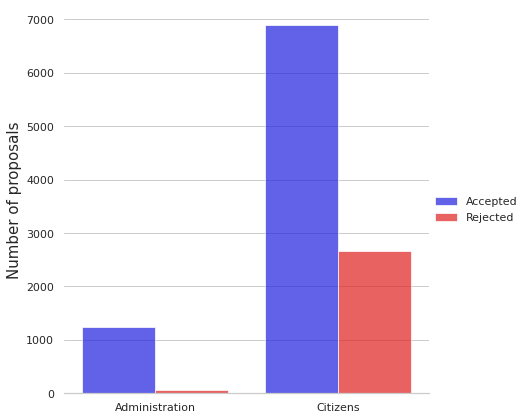

In [98]:
import seaborn as sns
plt.figure(figsize=(16,16))
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_aux, kind="bar",
    x="group_author", y="size", hue="status",
    ci="sd", palette=["blue", "red"], alpha=.7, height=6,
)
g.despine(left=True)
g.set_axis_labels("", "Number of proposals", fontsize=15)
g.legend.set_title("")
plt.savefig('../images/proposals_author.pdf', dpi = 300)

## 2. Actions

In [6]:
# Read proposals dataset
df_actions = pd.read_csv(config['ROOT_PATH'] + '/data/' + 'actions.csv', sep=',', encoding='utf-8')

In [7]:
df_actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1484 entries, 0 to 1483
Data columns (total 27 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        1484 non-null   int64  
 1   result_id                         1484 non-null   int64  
 2   decidim_category_id               1484 non-null   int64  
 3   decidim_scope_id                  1155 non-null   float64
 4   parent_id                         0 non-null      float64
 5   external_id                       0 non-null      float64
 6   start_date                        0 non-null      float64
 7   end_date                          0 non-null      float64
 8   decidim_accountability_status_id  0 non-null      float64
 9   progress                          0 non-null      float64
 10  proposal_ids                      1393 non-null   object 
 11  title_ca                          1484 non-null   object 
 12  descri

In [29]:
# Keep relevant columns
df_actions = df_actions[['result_id', 'proposal_ids', 'title_ca', 'description_ca' , 'Title Result ES' , 'Description Result ES']]

In [30]:
len(df_actions)

1484

In [31]:
# Clean the text
df_actions['Title Result ES'] = clean_text(df_actions['Title Result ES'])
df_actions['title_ca'] = clean_text(df_actions['title_ca'])
df_actions['Description Result ES'] = clean_text(df_actions['Description Result ES'])
df_actions['description_ca'] = clean_text(df_actions['description_ca'])

In [32]:
# Create a new dataset with one row per proposal
df_actions_aux = pd.concat([pd.Series(row['result_id'], str(row['proposal_ids']).split(';')) for _, row in df_actions.iterrows()]).reset_index()
df_actions_aux.columns = ['proposal', 'action']

In [33]:
# Clean the dataset
df_actions_aux = pd.merge(df_actions_aux, df_actions, left_on='action', right_on='result_id')
df_actions_aux = df_actions_aux.drop(columns=['result_id'])

df_actions_aux.columns = ['proposal', 'action', 'proposal_list', 'title_ca_action', 'description_ca_action' , 'title_es_action' , 'description_es_action']
df_actions_aux['proposal_list'] = df_actions_aux.proposal_list.str.split(';').tolist()

# Change some column types
df_actions_aux = df_actions_aux.astype({'action': 'object'})
df_actions_aux['action'] = df_actions_aux['action'].astype(str)

In [34]:
df_actions_aux.head()

,proposal,action,proposal_list,title_ca_action,description_ca_action,title_es_action,description_es_action
0,2305,2585,"[2305, 2372, 7012, 7115]",Millorar la qualitat de l'aire,"Incrementar l'espai de verd urbà impulsant mesures per revegetar interiors de patis d'illa, terrats i parets mitgeres i treure cotxes dels carrers, eliminant carrils de circulació per a vehicles a favor de carrils bici o bus.",Mejorar la calidad del aire,"Incrementar el espacio de verde urbano impulsando medidas para revegetar interiores de patios de manzana, azoteas y paredes medianeras y sacar coches de las calles, eliminando carriles de circulación para vehículos a favor de carriles bici o bus."
1,2372,2585,"[2305, 2372, 7012, 7115]",Millorar la qualitat de l'aire,"Incrementar l'espai de verd urbà impulsant mesures per revegetar interiors de patis d'illa, terrats i parets mitgeres i treure cotxes dels carrers, eliminant carrils de circulació per a vehicles a favor de carrils bici o bus.",Mejorar la calidad del aire,"Incrementar el espacio de verde urbano impulsando medidas para revegetar interiores de patios de manzana, azoteas y paredes medianeras y sacar coches de las calles, eliminando carriles de circulación para vehículos a favor de carriles bici o bus."
2,7012,2585,"[2305, 2372, 7012, 7115]",Millorar la qualitat de l'aire,"Incrementar l'espai de verd urbà impulsant mesures per revegetar interiors de patis d'illa, terrats i parets mitgeres i treure cotxes dels carrers, eliminant carrils de circulació per a vehicles a favor de carrils bici o bus.",Mejorar la calidad del aire,"Incrementar el espacio de verde urbano impulsando medidas para revegetar interiores de patios de manzana, azoteas y paredes medianeras y sacar coches de las calles, eliminando carriles de circulación para vehículos a favor de carriles bici o bus."
3,7115,2585,"[2305, 2372, 7012, 7115]",Millorar la qualitat de l'aire,"Incrementar l'espai de verd urbà impulsant mesures per revegetar interiors de patis d'illa, terrats i parets mitgeres i treure cotxes dels carrers, eliminant carrils de circulació per a vehicles a favor de carrils bici o bus.",Mejorar la calidad del aire,"Incrementar el espacio de verde urbano impulsando medidas para revegetar interiores de patios de manzana, azoteas y paredes medianeras y sacar coches de las calles, eliminando carriles de circulación para vehículos a favor de carriles bici o bus."
4,nan,2587,NaN,Posar en marxa programes de suport educatiu i de salut mental en sinergia amb l’entorn,"Posar en marxa, a les escoles i instituts més desafavorits, programes de suport educatiu i de salut mental en sinergia amb l’entorn, de manera que s’hi incorporin diferents agents socials (educadors socials, treballadors socials i psicòlegs) i entitats socials que puguin desenvolupar tasques d’assessorament i suport als professionals dels serveis socials.",Poner en marcha programas de apoyo educativo y de salud mental en sinergia con el entorno,"Poner en marcha, en las escuelas e institutos más desfavorecidos, programas de apoyo educativo y de salud mental en sinergia con el entorno, de manera que se incorporen diferentes agentes sociales (educadores sociales, trabajadores sociales y psicólogos) y entidades sociales que puedan desarrollar tareas de asesoramiento y apoyo a los profesionales de los servicios sociales."


**NOTE**: There are some actions that do not have any proposal.

In [35]:
# Merge actions with proposals
df_aux = pd.merge(df, df_actions_aux, on = 'proposal', how = 'outer')

In [36]:
# Clean
df_aux['proposal'] = df_aux.proposal.replace(r'nan', np.nan, regex=True)

In [37]:
# Content analysis


In [38]:
# Write final dataset
df_aux.to_csv(config['ROOT_PATH'] + '/data/' + 'proposals_clean.csv', sep=',', encoding='utf-8')